In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm

In [3]:
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [4]:
retail_df = pd.read_excel('input/Online Retail.xlsx')
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail_df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
retail_df = retail_df[retail_df['CustomerID'].notna()]
retail_df['Description'].fillna('',inplace=True)
retail_df.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
retail_df.shape

(406829, 8)

In [8]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df.shape

(397924, 8)

In [10]:
retail_df.drop(retail_df[retail_df['UnitPrice'] == 0].index, inplace=True)

In [11]:
retail_df.shape

(397884, 8)

In [12]:
retail_df['InvoiceDate'] = retail_df['InvoiceDate'].dt.date
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


In [13]:
retail_df['TotalPrice'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
 8   TotalPrice   397884 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 30.4+ MB


In [14]:
max_date = retail_df['InvoiceDate'].max() + timedelta(days=1)
X = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,
    'TotalPrice': 'sum',
    'InvoiceNo': 'count'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'TotalPrice': 'MonetryValue',
    'InvoiceNo': 'Frequency'
})
display(X.info())
display(X.head())

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Recency       4338 non-null   int64  
 1   MonetryValue  4338 non-null   float64
 2   Frequency     4338 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


None

,Recency,MonetryValue,Frequency
CustomerID,,,
12346.0,326,77183.60,1
12347.0,3,4310.00,182
12348.0,76,1797.24,31
12349.0,19,1757.55,73
12350.0,311,334.40,17


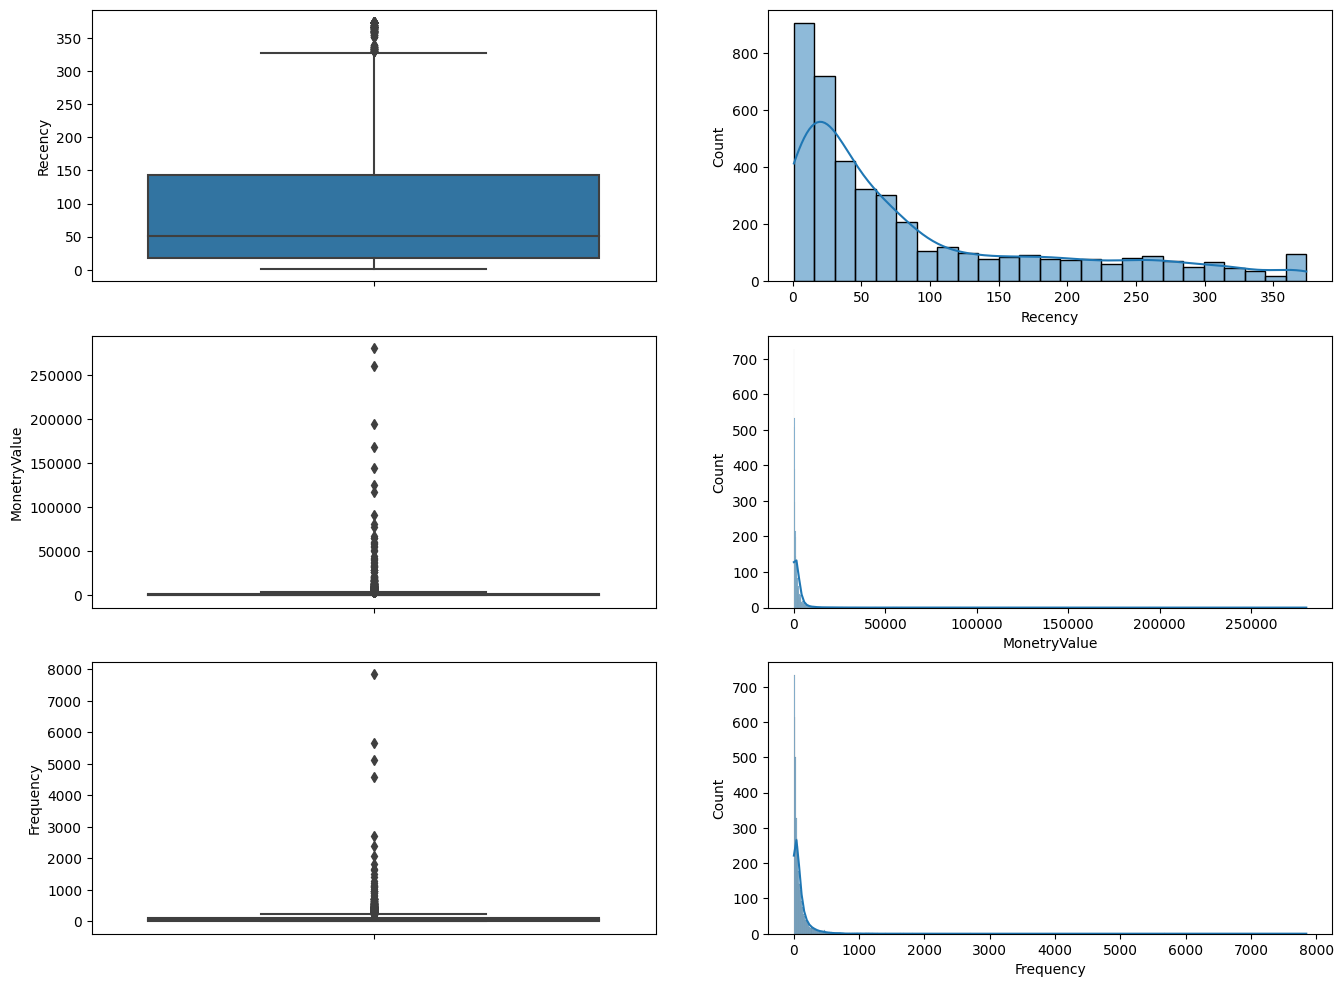

In [15]:
ncols = len(X.columns)
fig,axes = plt.subplots(ncols, 2, figsize=(16,ncols*4))

for i, col in enumerate(X.columns):
    sns.boxplot(X, y=col, ax=axes[i][0])
    sns.histplot(X, x=col, kde=True, ax=axes[i][1])

plt.show()

In [16]:
def remove_outliers(df, col, threshold=1.5):
    Q1 = np.quantile(df[col], 0.25)
    Q3 = np.quantile(df[col], 0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - IQR*threshold) & (df[col] <= Q3 + IQR*threshold)]

In [17]:
for col in X.columns:
    X = remove_outliers(X, col)

display(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3545 entries, 12348.0 to 18287.0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Recency       3545 non-null   int64  
 1   MonetryValue  3545 non-null   float64
 2   Frequency     3545 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 110.8 KB


None

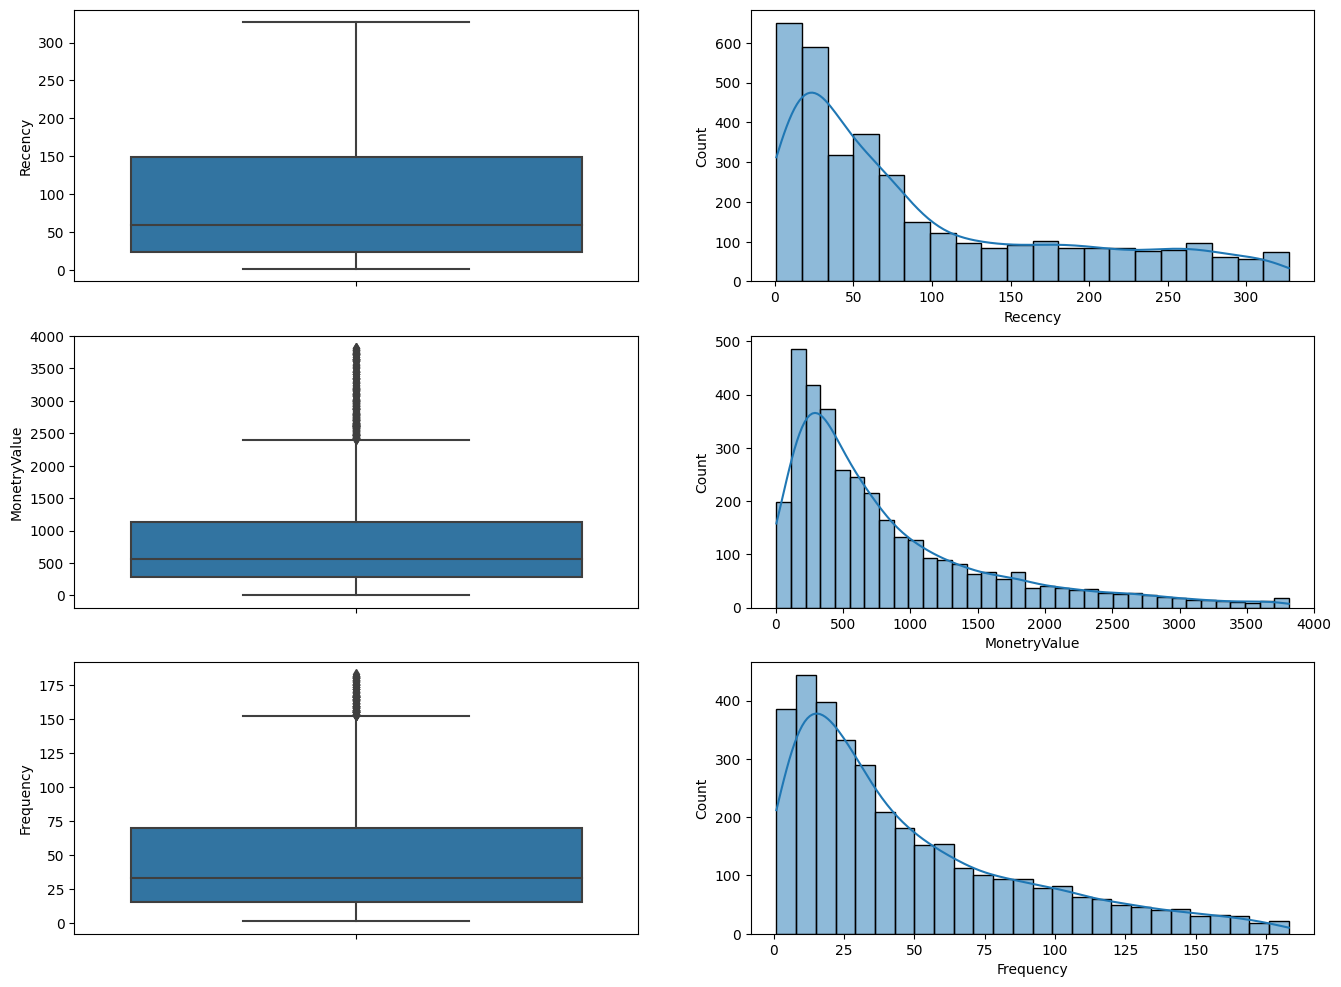

In [18]:
ncols = len(X.columns)
fig,axes = plt.subplots(ncols, 2, figsize=(16,ncols*4))

for i, col in enumerate(X.columns):
    sns.boxplot(X, y=col, ax=axes[i][0])
    sns.histplot(X, x=col, kde=True, ax=axes[i][1])

plt.show()

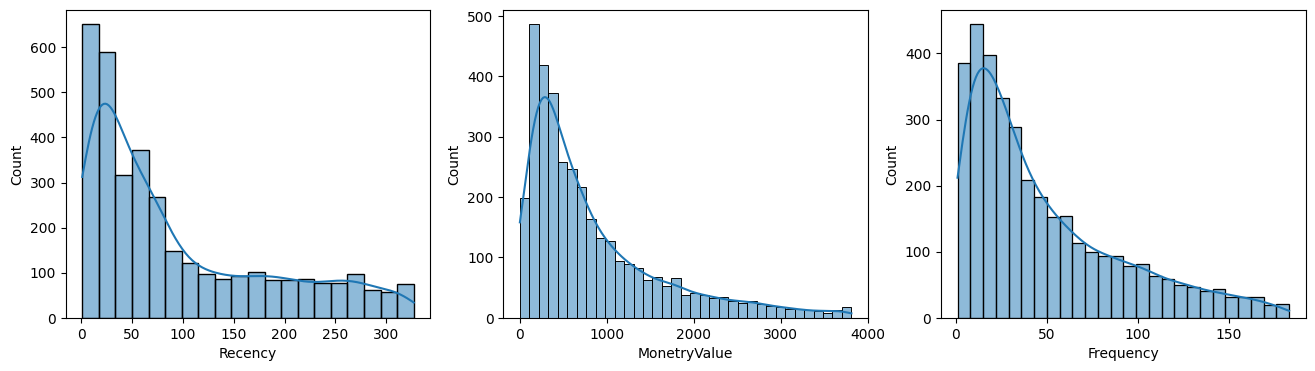

In [19]:
fig, axes = plt.subplots(1, ncols,figsize=(16,4))
for i,col in enumerate(X.columns):
    sns.histplot(X, x=col, kde=True, ax=axes[i])

plt.show()

In [20]:
boxcox_t = PowerTransformer(method='box-cox')
log_t = FunctionTransformer(func=np.log, inverse_func=np.exp)
sqrt_t = FunctionTransformer(func=np.sqrt, inverse_func=lambda x: x**2)
cbrt_t = FunctionTransformer(func=np.cbrt, inverse_func=lambda x: x**3)

X_box_cox = boxcox_t.fit_transform(X)
X_log = log_t.fit_transform(X).values
X_sqrt = sqrt_t.fit_transform(X).values
X_cbrt = cbrt_t.fit_transform(X).values

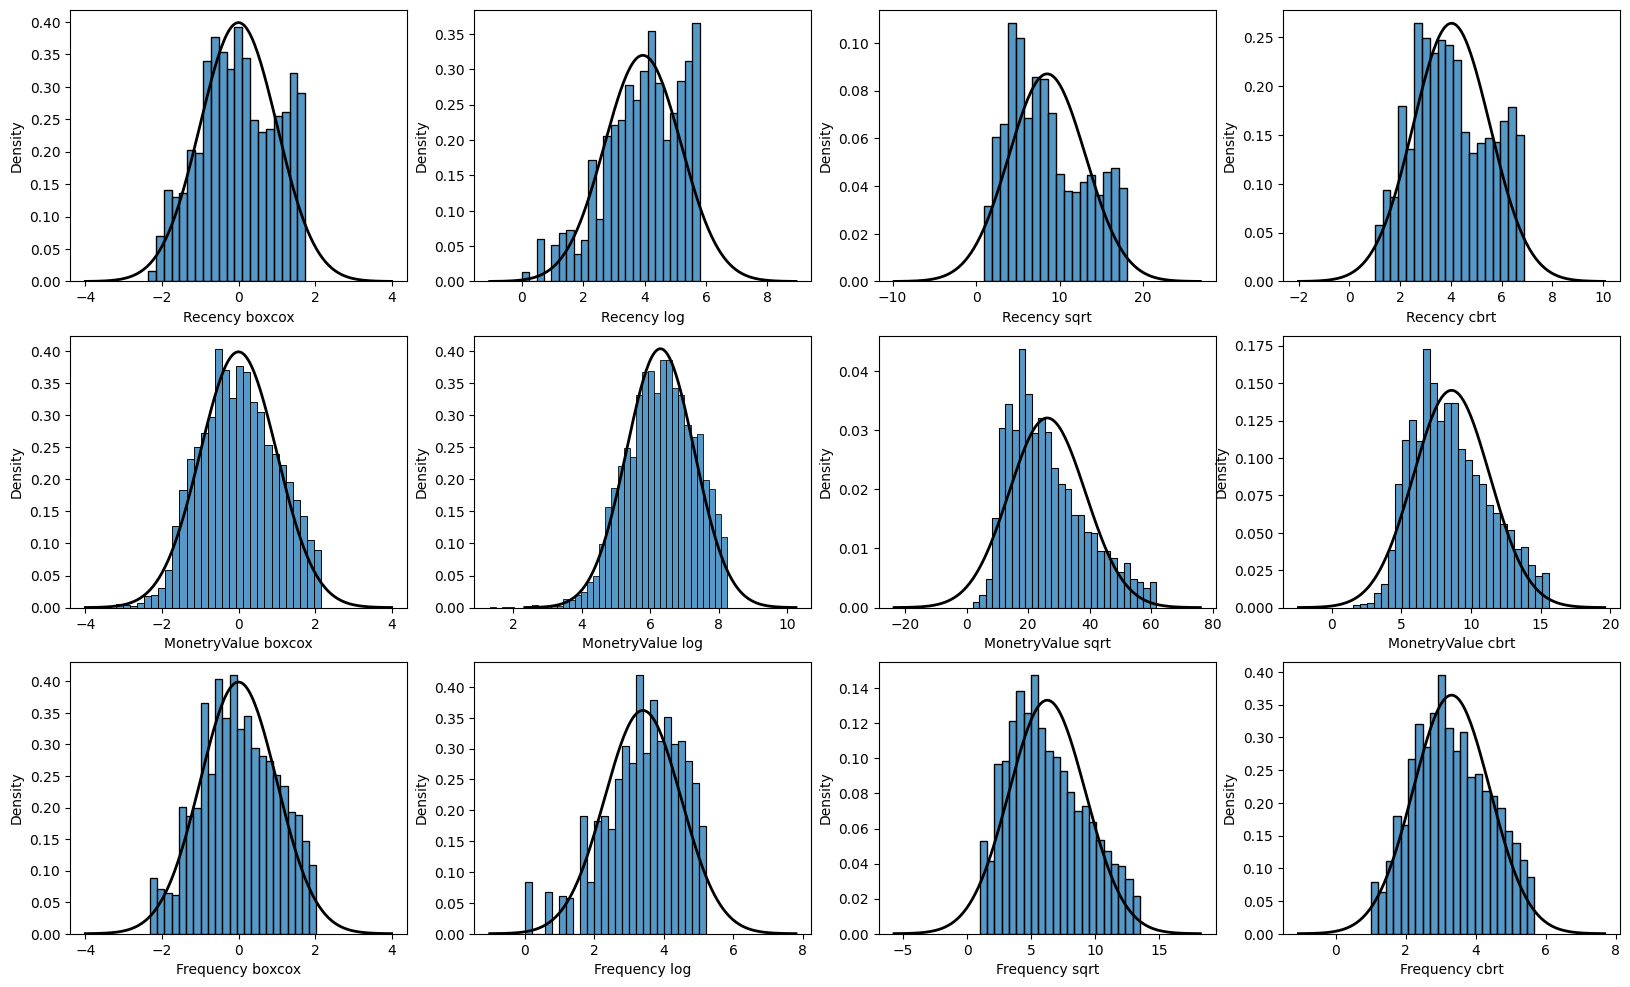

In [21]:
fig, axes = plt.subplots(ncols, 4, figsize=(20, 4*ncols))
def normal(mean, std, ax,color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = norm.pdf(x, mean, std)
    z = ax.plot(x, p, color, linewidth=2)
for i, col in enumerate(X.columns):
    sns.histplot(X_box_cox[:,i], stat='density', ax=axes[i][0])
    normal(X_box_cox[:,i].mean(), X_box_cox[:,i].std(), axes[i][0])
    axes[i][0].set_xlabel(f'{col} boxcox')

    sns.histplot(X_log[:,i], stat='density', ax=axes[i][1])
    normal(X_log[:,i].mean(), X_log[:,i].std(), axes[i][1])
    axes[i][1].set_xlabel(f'{col} log')

    sns.histplot(X_sqrt[:,i], stat='density', ax=axes[i][2])
    normal(X_sqrt[:,i].mean(), X_sqrt[:,i].std(), axes[i][2])
    axes[i][2].set_xlabel(f'{col} sqrt')

    sns.histplot(X_cbrt[:,i], stat='density', ax=axes[i][3])
    normal(X_cbrt[:,i].mean(), X_cbrt[:,i].std(), axes[i][3])
    axes[i][3].set_xlabel(f'{col} cbrt')
    
plt.show()

In [22]:
standard_scaler = StandardScaler()

transformer = ColumnTransformer([
    ('boxcox',boxcox_t,['MonetryValue']),
    ("cbrt", cbrt_t, ["Recency", "Frequency"])
], remainder='passthrough')

preprocessing = Pipeline([
    ("transformers", transformer),
    ("scaler", standard_scaler),
])

In [23]:
kmeans = KMeans(random_state=32)
clusterer = Pipeline([
    ("preprocessing", preprocessing),
    ("kmeans", kmeans),
])

/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

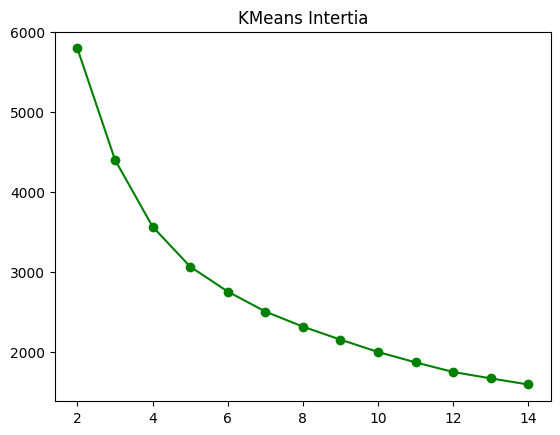

In [24]:
n_clusters = np.arange(2,15)
inertia = []
for k in n_clusters:
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    clusterer.fit(X)
    inertia.append(kmeans.inertia_)

plt.title("KMeans Intertia")
plt.plot(n_clusters, inertia, color="green", marker="o")
plt.show()

/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

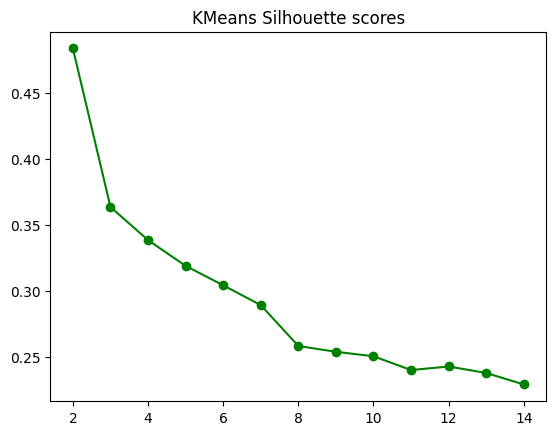

In [25]:
silhouette_scores = []
n_clusters = np.arange(2, 15)

def calculate_silhouttes(X, labels):
    avg_silhouette = silhouette_score(X, labels, random_state=32)
    silhouette_scores.append(avg_silhouette)

for i, k in enumerate(n_clusters):
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    labels = clusterer.fit_predict(X)
    X_transf = clusterer.transform(X)
    calculate_silhouttes(X_transf, labels)


plt.title("KMeans Silhouette scores")
plt.plot(n_clusters, silhouette_scores, color="green", marker="o")
plt.show()

In [26]:
# silhouette score is maximum for n = 2

kmeans = clusterer.steps[-1][1]
kmeans.set_params(n_clusters=2)
labels = clusterer.fit_predict(X)
X["Label"] = labels
X.head()

/home/anand/TataAIG/mail-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,MonetryValue,Frequency,Label
CustomerID,,,,
12348.0,76,1797.24,31,0
12349.0,19,1757.55,73,0
12350.0,311,334.40,17,1
12352.0,37,2506.04,85,0
12353.0,205,89.00,4,1
